## 문제 1

### 오픈API를 통해 데이터를 5천 ~ 1만 건 정도 수집해서 파일로 저장

In [1]:
%%writefile src/collected_data.py
# coding: utf-8
import os
import urllib
import requests
import mylib
import string

def doIt():
    _d=dict()
    _d['title']='1' 
    _d['manageCd']='MC'
    _d['numOfRows']='5000'
    _d['pageNo']='1'
    params2 = urllib.parse.urlencode(_d)

    keyPath=os.path.join(os.getcwd(), 'src', 'key.properties')
    key=mylib.getKey(keyPath)
    params='?'+'serviceKey='+key['gokr']+'&'+params2

    _url = 'http://openapi-lib.sen.go.kr/openapi/service/lib/openApi'
    url=urllib.parse.urljoin(_url,params)
    data=requests.get(url).text
    #print (data)
    
    f=open('src/collected_data.txt','w')
    f.write(data)
    
    f=open('src/collected_data.txt','r')
    lines=[]
    for paragraph in f:
        lines = str.split(paragraph, "</appendixYn>")
        for each_line in lines:
            if each_line.find('totalCount')>0:
                print ("읽은 데이터 수:",_d['numOfRows'])
                print (each_line)
            else:
                pass
    f.close()

if __name__ == "__main__":
    doIt()

Overwriting src/collected_data.py


#### 프로그램에서 몇 건을 읽었는지와 마지막 줄을 화면 출력

In [2]:
!python3 src/collected_data.py

읽은 데이터 수: 5000
<author>도로시 로 놀테;레이첼 해리스 [같이]지음;윤미연 옮김</author><bookKey>774820489</bookKey><callNo>598.1-ㄴ77어</callNo><controlNo>KMO200706580</controlNo><isbn>9788990514233</isbn><libName>강서도서관</libName><manageCode>MC</manageCode><pubYear>2007</pubYear><publisher>친구미디어</publisher><regNo>EMC000251781</regNo><rnum>5000</rnum><shelfLocName>[강서]2층 자료실서고(직원문의)</shelfLocName><speciesKey>774820487</speciesKey><title>(10대 자녀와 행복하게 소통하는)엄마 미션 127</title></item></items><numOfRows>5000</numOfRows><pageNo>1</pageNo><totalCount>18959</totalCount></body></response>


#### !dir 명령어로 파일이 존재하는지 출력 -> !ls 명령어

In [3]:
!ls ./src

__init__.ipynb              ds_open_subway_iter_json.py
__pycache__                 ds_open_subway_json.py
collected_data.json         ds_open_subway_xml.py
collected_data.py           hw_week2.txt
collected_data.txt          key.properties
ds_open_foreigners_xml.py   library.py
ds_open_library.py          mylib.py


## 문제 2

### spark 생성 & 버전 출력

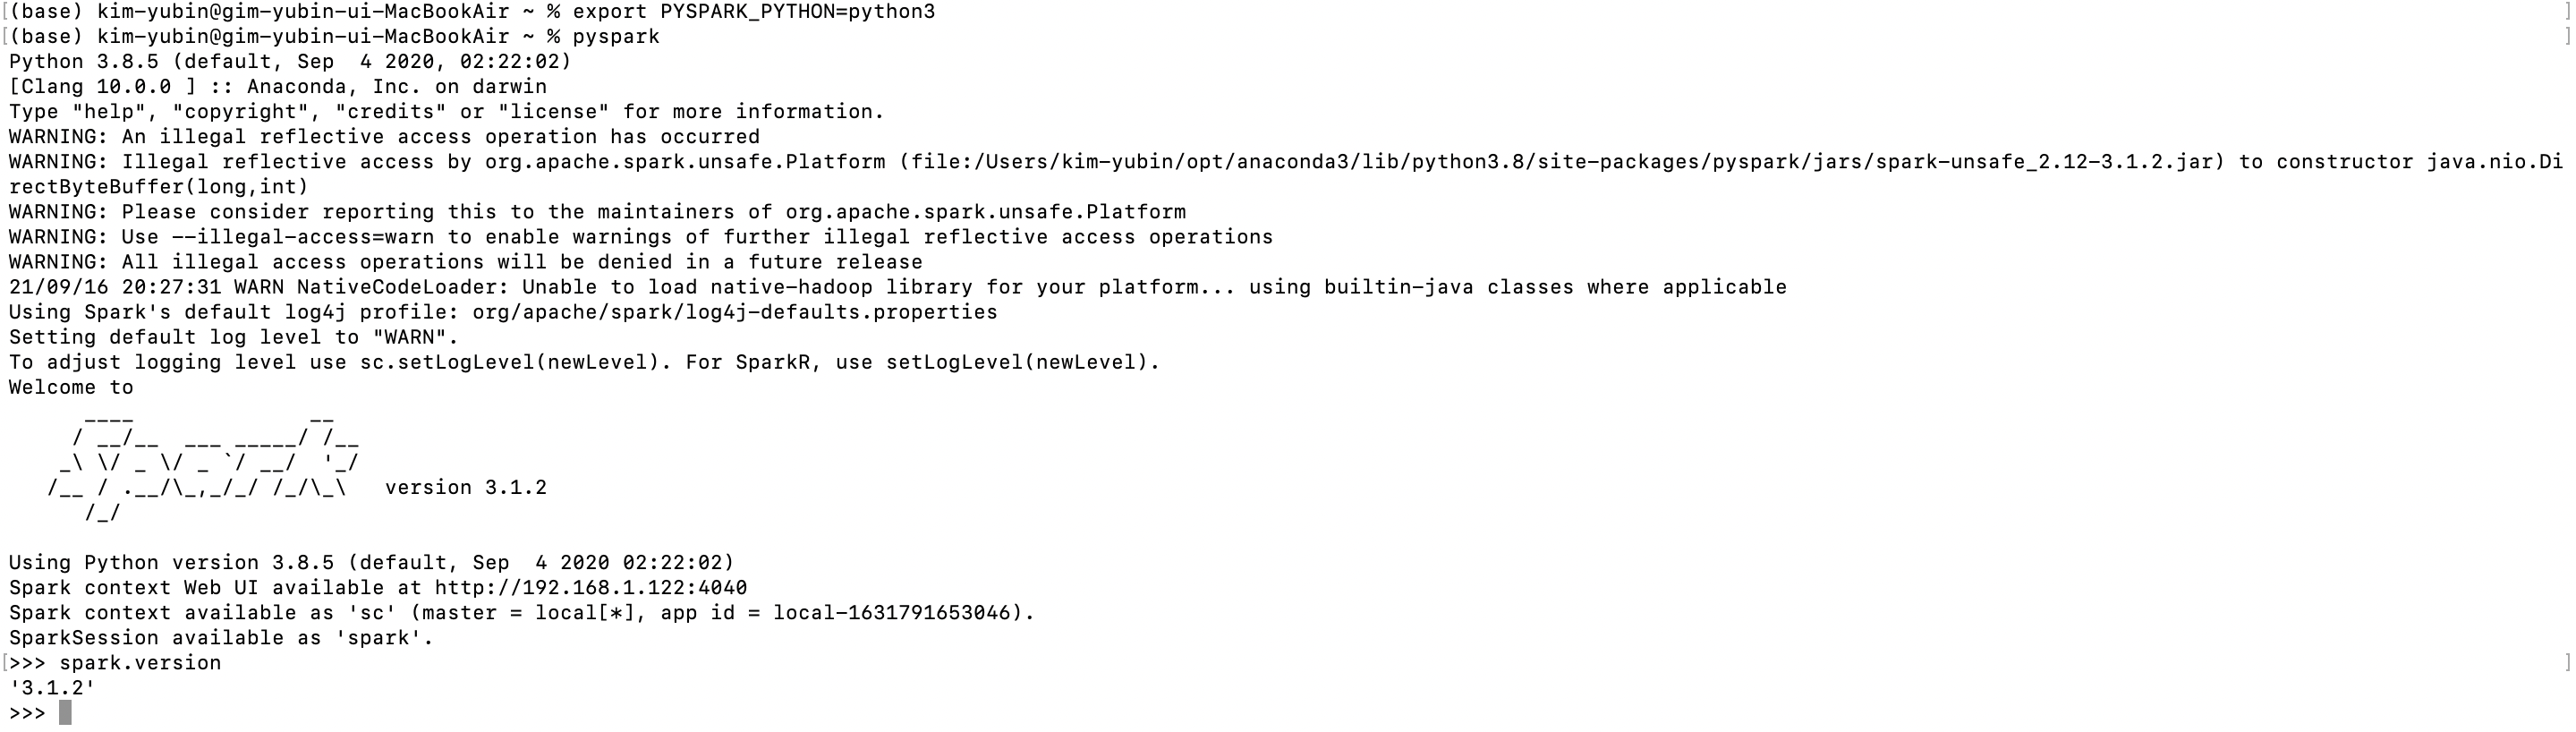

(base) kim-yubin@gim-yubin-ui-MacBookAir ~ % export PYSPARK_PYTHON=python3
(base) kim-yubin@gim-yubin-ui-MacBookAir ~ % pyspark
Python 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ] :: Anaconda, Inc. on darwin
Type "help", "copyright", "credits" or "license" for more information.
21/09/16 20:11:01 WARN Utils: Your hostname, gim-yubin-ui-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 192.168.1.122 instead (on interface en0)
21/09/16 20:11:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
WARNING: An illegal reflective access operation has occurred
WARNING: Illegal reflective access by org.apache.spark.unsafe.Platform (file:/Users/kim-yubin/opt/anaconda3/lib/python3.8/site-packages/pyspark/jars/spark-unsafe_2.12-3.1.2.jar) to constructor java.nio.DirectByteBuffer(long,int)
WARNING: Please consider reporting this to the maintainers of org.apache.spark.unsafe.Platform
WARNING: Use --illegal-access=warn to enable warnings of further illegal reflective access operations
WARNING: All illegal access operations will be denied in a future release
21/09/16 20:11:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/

Using Python version 3.8.5 (default, Sep  4 2020 02:22:02)
Spark context Web UI available at http://192.168.1.122:4040
Spark context available as 'sc' (master = local[*], app id = local-1631790663804).
SparkSession available as 'spark'.
>>> 

#### spark 버전

In [15]:
spark.version

'3.1.2'

#### pyspark 버전

In [4]:
import pyspark
print (pyspark.__version__)

3.1.2


### 버전 출력

In [5]:
!java --version

openjdk 11.0.11 2021-04-20
OpenJDK Runtime Environment AdoptOpenJDK-11.0.11+9 (build 11.0.11+9)
OpenJDK 64-Bit Server VM AdoptOpenJDK-11.0.11+9 (build 11.0.11+9, mixed mode)


In [6]:
!javac --version  #java 버전과 동일한지 확인

javac 11.0.11


In [7]:
!python --version  

Python 3.8.5


In [8]:
import sys

print(sys.version)  #자신이 사용하는 python 버전과 동일한지 확인

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


## 문제 3

### 파일을 읽어서 RDD 생성 & 5줄 화면출력

#### 1) 경기도 의정부시 인구현황 (파일명: ```경기도 의정부시_인구현황_20200904```) -> 파일 업데이트로 인해 다운로드한 파일명 변경

#### SparkSession 생성

In [9]:
import os
import pyspark

os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"

#myConf=pyspark.SparkConf().set("spark.driver.bindAddress", "127.0.0.1")
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [10]:
popRdd = spark.sparkContext\
    .textFile(os.path.join("data","경기도 의정부시_인구현황_20210910.csv"), use_unicode=True)

In [11]:
popRdd.take(5)

['행정기관,인구수(계),인구수(남),인구수(여),구성비(계),구성비(남),구성비(여),성비,세대수,세대당인구,관리기관명,관리부서명,부서전화번호,데이터기준일자',
 '의정부1동,32292,16538,15754,6.97,3.57,3.4,104.98,19998,1.61,의정부시,민원여권과,031-828-2466,2021-09-10',
 '의정부2동,31380,15608,15772,6.77,3.37,3.4,98.96,16410,1.91,의정부시,민원여권과,031-828-2466,2021-09-10',
 '호원1동,36124,17595,18529,7.8,3.8,4,94.96,15653,2.31,의정부시,민원여권과,031-828-2466,2021-09-10',
 '호원2동,34957,16923,18034,7.54,3.65,3.89,93.84,13683,2.55,의정부시,민원여권과,031-828-2466,2021-09-10']

In [12]:
for i in popRdd.take(5):
    print(i)

행정기관,인구수(계),인구수(남),인구수(여),구성비(계),구성비(남),구성비(여),성비,세대수,세대당인구,관리기관명,관리부서명,부서전화번호,데이터기준일자
의정부1동,32292,16538,15754,6.97,3.57,3.4,104.98,19998,1.61,의정부시,민원여권과,031-828-2466,2021-09-10
의정부2동,31380,15608,15772,6.77,3.37,3.4,98.96,16410,1.91,의정부시,민원여권과,031-828-2466,2021-09-10
호원1동,36124,17595,18529,7.8,3.8,4,94.96,15653,2.31,의정부시,민원여권과,031-828-2466,2021-09-10
호원2동,34957,16923,18034,7.54,3.65,3.89,93.84,13683,2.55,의정부시,민원여권과,031-828-2466,2021-09-10


####  2) 제주특별자치도 서귀포시 내 연도별 65세이상 인구수 및 고령화비율, 노령화지수 현황 (파일명: ```제주특별자치도 서귀포시_고령화비율및노령화지수현황_20200623```)

In [13]:
agedRdd = spark.sparkContext\
    .textFile(os.path.join("data","제주특별자치도 서귀포시_고령화비율및노령화지수현황_20210831.csv"), use_unicode=True)

In [14]:
for i in agedRdd.take(5):
    print(i)

연도별,서귀포시 인구수,65세이상 인구수,14세이하 인구수,고령화비율,노령화지수,데이터기준일자
2012,154057,25826,22861,16.76,112.97,2021-08-31
2013,155641,26936,22393,17.31,120.29,2021-08-31
2014,158512,27877,22058,17.59,126.38,2021-08-31
2015,164519,28979,22362,17.61,129.59,2021-08-31
